## Dependecies


In [1]:
from pathlib import Path
import sys
import copy
from torchvision import datasets
from tqdm.notebook import tqdm

## Utils


In [2]:
project_root = Path.cwd().resolve().parents[2]
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

data_root = project_root / "data"
data_root.mkdir(parents=True, exist_ok=True)

from notebook_setup import setup_notebook

setup_notebook()

Notebook setup completed. Project root added to sys.path: D:\Unlearning


In [3]:
# Device configuration
from utils.utils import DEVICE

print(f"Device used: {DEVICE}")

# Set random seed for reproducibility
from utils.utils import set_seed

set_seed()

from utils.utils import save_model

from models.effnetb0 import load_model_effnetb0, init_model_effnetb0

# Merics
from utils.train_test_metrics import test_model, show_metrics

# Recreate Dataloaders from json files
from methods.naive.naive_utils import recreate_dataloaders

# Fisher Information Matrix (FIM) calc and unlearning with FIM
from methods.fisher.fisher_utils import (
    iterative_fisher_unlearn,
    create_unlearning_dataloader,
)

Device used: cuda


## Parameters (arbitrary chosen)


In [4]:
BATCH_SIZE = 64
MINI_BATCH_SIZE = 256

SIGMA = 1

EPS = 1e-6
MAX_NORM = 0

# CALL FISHER


### Files


In [5]:
model_file = project_root / "results/animal_faces/naive/EffNetB0_AFHQ_model.pth"
samples_to_unlearn_file = (
    project_root / "results/animal_faces/naive/afhq_samples_to_unlearn_30per.json"
)
remaining_dataset_file = (
    project_root / "results/animal_faces/naive/updated_afhq_data_splits.json"
)

### Init models


In [6]:
original_model, original_model_name, criterion, _optimizer, transform = (
    load_model_effnetb0(model_pth_path=model_file)
)

model_to_unlearn = copy.deepcopy(original_model)
import torch.nn as nn

# model_to_unlearn = nn.DataParallel(model_to_unlearn, device_ids=[0, 1])

model_to_unlearn_name = "fisher_" + original_model_name

Load model...
Init model...
Done initializing model.
Model ID: 2596551587968, Optimizer ID: 2598015296480, Criterion ID: 2596551307664
Done loading model.


## Init data


In [7]:
train_dataset = datasets.ImageFolder(root=data_root / "afhq/train", transform=transform)
test_dataset = datasets.ImageFolder(root=data_root / "afhq/val", transform=transform)

In [8]:
unlearn_indices, _unlearn_loader = create_unlearning_dataloader(
    samples_to_unlearn_file, train_dataset, batch_size=MINI_BATCH_SIZE
)

In [ ]:
# train_loader, _val_loader, test_loader, classes = recreate_dataloaders(
#     data_splits_file=remaining_dataset_file,
#     datasets=(train_dataset, test_dataset),
#     batch_size=BATCH_SIZE)

# unlearn_loader = create_unlearning_dataloader(samples_to_unlearn_file, train_dataset, batch_size = MINI_BATCH_SIZE)

### FIM


In [ ]:
import math
import json
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader, Subset

from utils.utils import DEVICE


def compute_gradient_on_subset(model, criterion, dataset_subset, batch_size):
    """
    Compute the average gradient Δ_rem = ∇L(θ, D') over the given dataset_subset.
    """
    dataloader = DataLoader(dataset_subset, batch_size=batch_size, shuffle=False)

    grad_dict = {}
    total_samples = 0

    model.train()
    for inputs, targets in tqdm(dataloader, desc="Computing gradients"):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        model.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        current_batch = inputs.size(0)
        total_samples += current_batch
        for name, param in model.named_parameters():
            if param.requires_grad and param.grad is not None:
                if name not in grad_dict:
                    grad_dict[name] = param.grad.detach().clone() * current_batch
                else:
                    grad_dict[name] += param.grad.detach() * current_batch

    # Average gradients over the entire subset
    for name in grad_dict:
        grad_dict[name] /= total_samples

    return grad_dict


def compute_fisher_on_subset(model, criterion, dataset_subset, batch_size):
    """
    Compute a diagonal approximation of the Fisher Information Matrix F over the given dataset_subset.
    It averages the squared gradients.
    """
    dataloader = DataLoader(dataset_subset, batch_size=batch_size, shuffle=False)
    fisher_diag = {}
    total_samples = 0

    model.eval()
    for inputs, targets in tqdm(dataloader, desc="Computing Fisher"):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        model.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        current_batch = inputs.size(0)
        total_samples += current_batch
        for name, param in model.named_parameters():
            if param.requires_grad and param.grad is not None:
                if name not in fisher_diag:
                    fisher_diag[name] = (param.grad.detach() ** 2) * current_batch
                else:
                    fisher_diag[name] += (param.grad.detach() ** 2) * current_batch

    for name in fisher_diag:
        fisher_diag[name] /= total_samples

    return fisher_diag


def remove_from_fisher_incrementally(
    fisher_diag, model, criterion, dataset_removed, batch_size
):
    dataloader = DataLoader(dataset_removed, batch_size=batch_size, shuffle=False)
    total_removed_samples = 0

    model.eval()
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        model.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        batch_samples = inputs.size(0)
        total_removed_samples += batch_samples
        for name, param in model.named_parameters():
            if param.requires_grad and param.grad is not None:
                fisher_diag[name] -= (param.grad.detach() ** 2) * batch_samples

    total_samples_remaining = fisher_diag["_total_samples"] - total_removed_samples
    for name in fisher_diag:
        if name != "_total_samples":
            fisher_diag[name] = torch.clamp(fisher_diag[name], min=1e-8)
            fisher_diag[name] /= total_samples_remaining
    fisher_diag["_total_samples"] = total_samples_remaining

    return fisher_diag


def iterative_fisher_unlearn(
    model,
    criterion,
    full_dataset,
    removal_indices,
    sigma,
    deletion_batch_size,
    compute_batch_size,
    eps,
    max_norm,
):
    """
    Implements the iterative Fisher unlearning procedure following theory:

    Inputs:
      - model: a pretrained PyTorch model (trained on full dataset D).
      - criterion: loss function (e.g., CrossEntropyLoss).
      - full_dataset: the full training dataset D (e.g., MNIST training set).
      - removal_indices: list of indices (from the JSON file) to be deleted (Dₘ). E.g., 6000 samples.
      - sigma: noise parameter σ.
      - deletion_batch_size: desired mini-batch size for deletion (m′). E.g., 1000.
      - compute_batch_size: batch size used when computing gradients/Fisher (BATCH_SIZE).
      - eps: for numerical stability

    Procedure:
      1. Let current_indices = set(range(len(full_dataset))).
      2. Partition removal_indices into mini-batches of size deletion_batch_size.
      3. For each mini-batch, update current_indices by removing those indices.
      4. Create a Subset from full_dataset using current_indices (this is D').
      5. Compute Δ_rem and diagonal Fisher F on D' and update model:
             θ ← θ − F⁻¹ Δ_rem + σ · F^(–1/4) · ε.
    """
    full_size = len(full_dataset)
    current_indices = set(range(full_size))

    # Partition removal_indices into mini-batches, where s = m /m'
    removal_list = list(removal_indices)
    num_batches = math.ceil(len(removal_list) / deletion_batch_size)
    partitioned_removals = [
        removal_list[i * deletion_batch_size : (i + 1) * deletion_batch_size]
        for i in range(num_batches)
    ]
    print(
        f"Total deletion samples: {len(removal_list)}; partitioned into {num_batches} mini-batches (each up to {deletion_batch_size} samples)."
    )

    # Iterate over each deletion mini-batch
    for i, batch in enumerate(
        tqdm(partitioned_removals, desc="Fisher step over mini-batches")
    ):
        # Remove the current batch of indices from current_indices
        current_indices -= set(batch)
        updated_indices = sorted(list(current_indices))
        # Create a Subset corresponding to the updated dataset D' = D \ (deleted so far)
        dataset_remaining = Subset(full_dataset, updated_indices)
        print(
            f"Iteration {i+1}/{num_batches}: Remaining dataset size = {len(dataset_remaining)}"
        )

        # Compute the average gradient and diagonal Fisher on D'
        grad_dict = compute_gradient_on_subset(
            model, criterion, dataset_remaining, compute_batch_size
        )
        fisher_diag = compute_fisher_on_subset(
            model, criterion, dataset_remaining, compute_batch_size
        )
        # Update model parameters using the Newton correction and noise injection
        with torch.no_grad():
            for name in grad_dict:
                grad = grad_dict[name]
                norm = grad.norm(2).item()
                grad_min = grad.min().item()
                grad_max = grad.max().item()
                grad_mean = grad.mean().item()
                grad_std = grad.std().item()
                print(
                    f"[Raw] Param {name}: norm = {norm:.4e}, min = {grad_min:.4e}, max = {grad_max:.4e}, mean = {grad_mean:.4e}, std = {grad_std:.4e}"
                )

            # First, compute and clip gradients, and monitor norms
            total_grad_norm_before = 0.0
            total_grad_norm_after = 0.0
            for name in grad_dict:
                norm_before = grad_dict[name].norm(2)
                total_grad_norm_before += norm_before.item()
                if norm_before > max_norm:
                    grad_dict[name] = grad_dict[name] * (max_norm / norm_before)
                norm_after = grad_dict[name].norm(2)
                total_grad_norm_after += norm_after.item()

            print(
                f"Iteration {i+1}: Total gradient norm before clipping = {total_grad_norm_before:.4f}"
            )
            print(
                f"Iteration {i+1}: Total gradient norm after clipping  = {total_grad_norm_after:.4f}"
            )

            # Now, update model parameters using the clipped gradients and monitor the Newton update norm
            total_update_norm = 0.0
            for name, param in model.named_parameters():
                if param.requires_grad:
                    inv_fisher = (fisher_diag[name] + eps).pow(-1)
                    newton_update = inv_fisher * grad_dict[name]
                    total_update_norm += newton_update.norm(2).item()
                    param.data = param.data - newton_update

                    inv_fisher_quarter = (fisher_diag[name] + eps).pow(-0.25)
                    noise = torch.randn_like(param.data)
                    param.data = param.data + sigma * inv_fisher_quarter * noise

            print(
                f"Iteration {i+1}: Total Newton update norm = {total_update_norm:.4f}"
            )
        print(f"Iteration {i+1}/{num_batches} update completed.")

    return model

In [ ]:
import time

start_time = time.perf_counter()

unlearned_model = iterative_fisher_unlearn(
    model_to_unlearn,
    criterion,
    train_dataset,
    unlearn_indices,
    SIGMA,
    deletion_batch_size=MINI_BATCH_SIZE,
    compute_batch_size=BATCH_SIZE,
    eps=EPS,
    max_norm=MAX_NORM,
)

end_time = time.perf_counter()  # End timer
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time:.6f} seconds")

### Unlearn


In [ ]:
save_model(unlearned_model, f"{model_to_unlearn_name}_model.pth")

In [9]:
from torch.utils.data import DataLoader

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
classes = test_dataset.classes

### Test and metrics


In [10]:
results_path = Path("D:/Unlearning/results/animal_faces/fisher")

In [26]:
model, *_ = init_model_effnetb0()
# model = nn.DataParallel(model, device_ids=[0, 1])
model_path = project_root / "results/animal_faces/fisher" / f"{model_to_unlearn_name}_model_v3.pth"
test_model(model, model_to_unlearn_name, model_path, test_loader, results_path=results_path)

Init model...
Done initializing model.
Model ID: 2598473873248, Optimizer ID: 2598473863216, Criterion ID: 2598473862160
Loading and testing model: fisher_EffNetB0_AFHQ


Evaluating model: D:\Unlearning\results\animal_faces\fisher\fisher_EffNetB0_AFHQ_model_v3.pth: 100%|██████████| 24/24 [00:15<00:00,  1.53it/s]

Predictions and labels saved to fisher_EffNetB0_AFHQ_predictions.json


Metrics for fisher_EffNetB0_AFHQ:
  - Test Accuracy: 0.3393
  - Precision: 0.3920
  - Recall: 0.3393
  - F1 Score: 0.2571


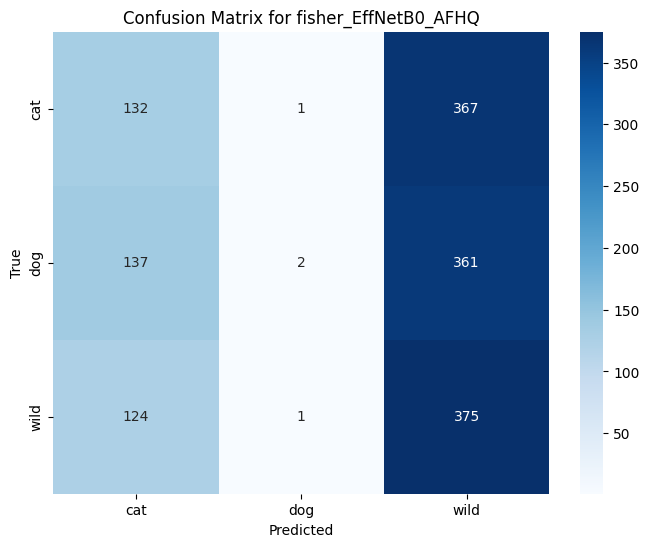

In [27]:
predictions_path = results_path / f"{model_to_unlearn_name}_predictions.json"
# classes = ['cat', 'dog', 'wildlife']
show_metrics(predictions_path, classes, model_to_unlearn_name)